# MILESTONE P4 : CREATIVE EXTENSION

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import math
import matplotlib.image as mpimg
import haversine as hvrs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import folium
import networkx as nx
import reverse_geocoder as rg
%matplotlib inline

# The data 

In [2]:
DATA_FOLDER = 'data/'

GOWALLA_CHECKINS_DATASET = DATA_FOLDER+"loc-gowalla_totalCheckins.txt.gz"
BRIGHTKITE_CHECKINS_DATASET = DATA_FOLDER+"loc-brightkite_totalCheckins.txt.gz"
POPULATION_DATASET = DATA_FOLDER+"pop_per_country.csv"
COUNTRY_CODES = DATA_FOLDER+"countrycodes.csv"
LANGUAGE_COUNTRIES = DATA_FOLDER+"languages.xlsx"
COUNTRIES_GDP = DATA_FOLDER+"countries_of_the_world.csv"
CONTINENTS = DATA_FOLDER+"conti_country.csv"

In [3]:
gowalla_checkins = pd.read_csv(GOWALLA_CHECKINS_DATASET, compression = 'gzip', delimiter = '\t', names = ['user', 'time', 'lat', 'lon', 'location_id'], header=None)
brightkite_checkins = pd.read_csv(BRIGHTKITE_CHECKINS_DATASET, compression = 'gzip', delimiter = '\t', names = ['user', 'time', 'lat', 'lon', 'location_id'], header=None)
population = pd.read_csv(POPULATION_DATASET, index_col = 0, names = ['country', 'population'], header = 0)
country_codes = pd.read_csv(COUNTRY_CODES, sep =',')
languages = pd.read_excel(LANGUAGE_COUNTRIES, names = ['country', 'language'])
continents = pd.read_csv(CONTINENTS, delimiter = ',', header = 0, usecols = [1,2,4,6], names = ['country', 'code', 'region', 'continent'])
countries_gdp = pd.read_csv(COUNTRIES_GDP, delimiter = ',', usecols = [0, 8], names = ['country', 'gdp'], header = 0)

# 0. Preliminary work 

## 0.1 Cleaning the data

In [4]:
gowalla_checkins.head(3)

,user,time,lat,lon,location_id
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637


In [5]:
# Preprocessing data to remove weird or null points

null_points = brightkite_checkins[(brightkite_checkins['lat'] == 0) & (brightkite_checkins['lon'] == 0)]
brightkite_checkins.drop(null_points.index, inplace = True)
null_points = gowalla_checkins[(gowalla_checkins['lat'] == 0) & (gowalla_checkins['lon'] == 0)]
gowalla_checkins.drop(null_points.index, inplace = True)
outliers_lat_B = brightkite_checkins[(brightkite_checkins['lat'] < -90) | (brightkite_checkins['lat'] > 90)]
brightkite_checkins.drop(outliers_lat_B.index, inplace = True)
outliers_lat_G = gowalla_checkins[gowalla_checkins['lat'] > 90]
gowalla_checkins.drop(outliers_lat_G.index, inplace = True)
brightkite_checkins.dropna(inplace = True)
gowalla_checkins.dropna(inplace = True)

## 0.2 Defining a home location to each user

We will compute distances with respect to latitudes and longitudes according to the following formulas :

**Latitude: 1 deg = 110.574 km**

**Longitude: 1 deg = 111.320*cos(latitude) km**

Source : https://stackoverflow.com/questions/1253499/simple-calculations-for-working-with-lat-lon-and-km-distance

In [6]:
def latitude_to_distance(lat1, lat2):
    ''' returns the distance in km between two given latitudes'''
    return((lat2 - lat1)*110.574)

In [7]:
def longitude_to_distance(lat, long1, long2):
    ''' returns the distance in km between two given longitudes with respect to the latitude'''
    return((long2 - long1)*111.320*np.cos(lat*np.pi/180)) # the latitude must be given in radians in the cosinus

In [8]:
gowalla_checkins['latitude_cell_number'] = latitude_to_distance(0, gowalla_checkins['lat'])//25
gowalla_checkins['longitude_cell_number'] = longitude_to_distance(gowalla_checkins['lat'], 0, gowalla_checkins['lon'])//25

brightkite_checkins['latitude_cell_number'] = latitude_to_distance(0, brightkite_checkins['lat'])//25
brightkite_checkins['longitude_cell_number'] = longitude_to_distance(brightkite_checkins['lat'], 0, brightkite_checkins['lon'])//25

In [9]:
# Here, I am counting the number of check-ins in all cell for each user
cells_counting_gowalla = gowalla_checkins.groupby(['user', 'latitude_cell_number', 'longitude_cell_number'], as_index = False).count()
cells_counting_gowalla.drop(columns = ['time', 'lat', 'lon'], inplace = True) # these are the same counting columns 
cells_counting_gowalla.rename(columns={"location_id": "count"}, inplace=True) # I only kept one that is renamed "count"

cells_counting_brightkite = brightkite_checkins.groupby(['user', 'latitude_cell_number', 'longitude_cell_number'], as_index = False).count()
cells_counting_brightkite.drop(columns = ['time', 'lat', 'lon'], inplace = True)
cells_counting_brightkite.rename(columns={"location_id": "count"}, inplace=True)

cells_counting_gowalla.head(5)

,user,latitude_cell_number,longitude_cell_number,count
0,0,133.0,-377.0,38
1,0,133.0,-376.0,95
2,0,134.0,-376.0,8
3,0,145.0,-363.0,1
4,0,151.0,-358.0,1


In [10]:
# The maximum number of check-ins in one cell for a given user is identified as count_max 
cells_counting_gowalla['count_max'] = cells_counting_gowalla.groupby(['user'])['count'].transform(max)
cells_counting_brightkite['count_max'] = cells_counting_brightkite.groupby(['user'])['count'].transform(max)
cells_counting_gowalla.head(5)

,user,latitude_cell_number,longitude_cell_number,count,count_max
0,0,133.0,-377.0,38,95
1,0,133.0,-376.0,95,95
2,0,134.0,-376.0,8,95
3,0,145.0,-363.0,1,95
4,0,151.0,-358.0,1,95


In [11]:
# I am only interested in the rows with a maximum count (i.e. when count = count_max).
# Therefore, I create a new dataframe that will conly contain these "maximum rows". 
home_cell_gowalla = cells_counting_gowalla[cells_counting_gowalla['count'] == cells_counting_gowalla['count_max']].copy()
home_cell_gowalla.drop(columns = ['count_max'], inplace = True) # the count_max column is not useful anymore beacause count = count_max in this dataframe

home_cell_brightkite = cells_counting_brightkite[cells_counting_brightkite['count'] == cells_counting_brightkite['count_max']].copy()
home_cell_brightkite.drop(columns = ['count_max'], inplace = True)

Now I know the cells with the largest number of check-ins for each user. But for several users, there are many cells with the same maximum number of check-ins. Therefore, I have to find a fair way to chose which cell will be used to compute to home location. 

Unfortunately, this case is not clearly explained in the original study. 

Therefore I will determine the "**averaged cell**" among cells with an equal maximal number of check-ins. By "averaged cell", I mean the cell with coordinates corresponding to the **average coordinates of all maximum cells**. If the averaged cell is one of the maximum cells (which is not necessarily the case), it will naturally be defined as the home cell. But, if it is not the case, I will chose a cell randomly among the cells with an equal maximal number of check-ins.

In [12]:
# I create new dataframes that will contain the averaged home cell 
average_cell_gowalla = pd.DataFrame({'user':home_cell_gowalla.user.unique()}, index = home_cell_gowalla.user.unique())
average_cell_brightkite = pd.DataFrame({'user':home_cell_brightkite.user.unique()}, index = home_cell_brightkite.user.unique())

In [13]:
# I compute the mean cell numbers of latitude and longitude, for each user. 

average_cell_gowalla['average_cell_latitude'] = home_cell_gowalla.groupby('user')['latitude_cell_number'].mean()
average_cell_gowalla['average_cell_longitude'] = home_cell_gowalla.groupby('user')['longitude_cell_number'].mean()

average_cell_brightkite['average_cell_latitude'] = home_cell_brightkite.groupby('user')['latitude_cell_number'].mean()
average_cell_brightkite['average_cell_longitude'] = home_cell_brightkite.groupby('user')['longitude_cell_number'].mean()

But now, I have cells numbers that are not always integers, I will use the *round()* function to correct this. 

In [14]:
average_cell_gowalla['average_cell_latitude'] = round(average_cell_gowalla['average_cell_latitude'])
average_cell_gowalla['average_cell_longitude'] = round(average_cell_gowalla['average_cell_longitude'])

average_cell_brightkite['average_cell_latitude'] = round(average_cell_brightkite['average_cell_latitude'])
average_cell_brightkite['average_cell_longitude'] = round(average_cell_brightkite['average_cell_longitude'])

I have to compare these averaged cell numbers to the ones that I had before, and see if there is a match or not. 

If the averaged cell numbers are the one of a maximum check-ins cell that I had before, it will be defined as the home cell. If not, the home cell will be chosen randomly among the maximum check-ins cells. 

In [15]:
# To do this, I compute the intersection between the previous cells and the averaged cells. 
# Therefore, the cells with a match will be in these new dataframes. 

unique_home_cell_gowalla = pd.merge(home_cell_gowalla, average_cell_gowalla, how = 'inner', left_on = ['user', 'latitude_cell_number', 'longitude_cell_number'], right_on = ['user', 'average_cell_latitude', 'average_cell_longitude'])
unique_home_cell_gowalla.drop(columns = ['average_cell_latitude', 'average_cell_longitude'], inplace = True)

unique_home_cell_brightkite = pd.merge(home_cell_brightkite, average_cell_brightkite, how = 'inner', left_on = ['user', 'latitude_cell_number', 'longitude_cell_number'], right_on = ['user', 'average_cell_latitude', 'average_cell_longitude'])
unique_home_cell_brightkite.drop(columns = ['average_cell_latitude', 'average_cell_longitude'], inplace = True)

unique_home_cell_gowalla.head(3)                                                                    

,user,latitude_cell_number,longitude_cell_number,count
0,0,133.0,-376.0,95
1,2,150.0,-437.0,696
2,4,167.0,-431.0,136


In [16]:
# For the user that did not get a match with their averaged home cell, I will chose a random cell.
# To do this, I start by defining which user are in that case. 

all_user_gowalla = list(home_cell_gowalla.user.unique())
user_with_home_gowalla = list(unique_home_cell_gowalla.user.unique())
user_without_home_gowalla = list(set(all_user_gowalla) - set(user_with_home_gowalla))

all_user_brightkite = list(home_cell_brightkite.user.unique())
user_with_home_brightkite = list(unique_home_cell_brightkite.user.unique())
user_without_home_brightkite = list(set(all_user_brightkite) - set(user_with_home_brightkite))

In [17]:
# Now that I have the list of the users who does not have a home cell yet, I will add a row to the unique_home_cell
# dataframes with one of their maximum check-ins cell chosen randomly, thanks to the sample() function. 

for i in user_without_home_gowalla:
    unique_home_cell_gowalla = unique_home_cell_gowalla.append(home_cell_gowalla[home_cell_gowalla.user == i].sample(1), ignore_index = True)
unique_home_cell_gowalla.sort_values(by = ['user'], inplace = True)

for i in user_without_home_brightkite:
    unique_home_cell_brightkite = unique_home_cell_brightkite.append(home_cell_brightkite[home_cell_brightkite.user == i].sample(1), ignore_index = True)
unique_home_cell_brightkite.sort_values(by = ['user'], inplace = True)

In [18]:
unique_home_cell_gowalla.head(3)

,user,latitude_cell_number,longitude_cell_number,count
0,0,133.0,-376.0,95
103320,1,203.0,20.0,1
1,2,150.0,-437.0,696


**As you can see, each user has now a unique home cell.** Each user has a unique row containing his or her home cell in the *unique_home_cell* dataframes. 

We can therefore compute the home location within these home cells !

In [19]:
# I create new dataframes that only contain the check-ins that are located in the home cell defined previously. 
# To do this, I merge (by the inner method in order to get the intersection) the dataframe containing all ckeck-ins
# and the dataframe containing the home cell.  

home_checkins_gowalla = pd.merge(unique_home_cell_gowalla, gowalla_checkins, how = 'inner', on = ['user', 'latitude_cell_number', 'longitude_cell_number'])
home_checkins_brightkite = pd.merge(unique_home_cell_brightkite, brightkite_checkins, how = 'inner', on = ['user', 'latitude_cell_number', 'longitude_cell_number'])

In [20]:
# I compute the home location in new dataframes. The home location is obtained by computing the means of longitude
# and latitude of check-ins (for each user) that are in the dataframes I've just created. 

gowalla_home_locations = pd.DataFrame({'user':home_cell_gowalla.user.unique()}, index = home_cell_gowalla.user.unique())
gowalla_home_locations['home_latitude'] = home_checkins_gowalla.groupby('user')['lat'].mean()
gowalla_home_locations['home_longitude'] = home_checkins_gowalla.groupby('user')['lon'].mean()

brightkite_home_locations = pd.DataFrame({'user':home_cell_brightkite.user.unique()}, index = home_cell_brightkite.user.unique())
brightkite_home_locations['home_latitude'] = home_checkins_brightkite.groupby('user')['lat'].mean()
brightkite_home_locations['home_longitude'] = home_checkins_brightkite.groupby('user')['lon'].mean()

In [21]:
brightkite_home_locations.head()

,user,home_latitude,home_longitude
0,0,39.746677,-104.973619
1,1,37.602712,-122.377186
2,2,39.738340,-104.960762
3,3,37.670403,-122.406295
4,4,60.173672,24.942450


**Each user home is now well defined !**

## 0.3 Giving a country to each check-in and each home location

The following part has only be run once as it is quite long. 
The resulting dataframes as been saved as csv files to avoid doing these calculations every time we had to run the notebook. We hope that this is ok for you. All the code we used is still presented here. 

In [22]:
# For home locations
L_G = [] #list of home locations coordinates
for i in range(len(gowalla_home_locations)):
    L_G += [(gowalla_home_locations.iat[i, 1], gowalla_home_locations.iat[i, 2])]
results_G = rg.search(L_G)
gowalla_home_locations['country'] = [results_G[i].get('cc') for i in range(len(gowalla_home_locations))]
gowalla_home_locations.sample(3)

Loading formatted geocoded file...


,user,home_latitude,home_longitude,country
186815,186815,59.426259,10.637653,NO
81640,81640,-36.087586,146.909489,AU
4761,4761,32.686201,-97.070517,US


In [23]:
# same for Brightkite
L_B = []
for i in range(len(brightkite_home_locations)):
    L_B += [(brightkite_home_locations.iat[i, 1], brightkite_home_locations.iat[i, 2])]
results_B = rg.search(L_B)
brightkite_home_locations['country'] = [results_B[i].get('cc') for i in range(len(brightkite_home_locations))]

In [24]:
# And for the check-ins
L_G_checkins = []
for i in range(len(gowalla_checkins)):
    L_G_checkins += [(gowalla_checkins.iat[i, 2], gowalla_checkins.iat[i, 3])]
results_G_checkins = rg.search(L_G_checkins)
gowalla_checkins['country'] = [results_G_checkins[i].get('cc') for i in range(len(gowalla_checkins))]

In [25]:
# same for Brightkite
L_B_checkins = []
for i in range(len(brightkite_checkins)):
    L_B_checkins += [(brightkite_checkins.iat[i, 2], brightkite_checkins.iat[i, 3])]
results_B_checkins = rg.search(L_B_checkins)
brightkite_checkins['country'] = [results_B_checkins[i].get('cc') for i in range(len(brightkite_checkins))]

In [26]:
brightkite_home_locations.to_csv('data/home_loc_B.csv', sep = ';')
gowalla_home_locations.to_csv('data/home_loc_G.csv', sep = ';')

brightkite_checkins.to_csv('data/B_loc_country.csv', sep = ';')
gowalla_checkins.to_csv('data/G_loc_country.csv', sep = ';')

### !! Updating the data : check-ins and home location with countries !!

As said previously, we will use the csv files that were created with the code above. 

In [27]:
GOWALLA_CHECKINS_DATASET_UPDATE = DATA_FOLDER+"G_loc_country.csv"
GOWALLA_HOME_LOCATIONS = DATA_FOLDER+"home_loc_G.csv"
BRIGHTKITE_CHECKINS_DATASET_UPDATE = DATA_FOLDER+"B_loc_country.csv"
BRIGHTKITE_HOME_LOCATIONS = DATA_FOLDER+"home_loc_B.csv"

In [28]:
gowalla_checkins = pd.read_csv(GOWALLA_CHECKINS_DATASET_UPDATE, delimiter = ';', usecols = range(1,9))
gowalla_home_locations = pd.read_csv(GOWALLA_HOME_LOCATIONS, sep =';', usecols = [1,2,3,4], names = ['user', 'lat', 'lon', 'country'], header = 0)
brightkite_checkins = pd.read_csv(BRIGHTKITE_CHECKINS_DATASET_UPDATE, delimiter = ';', usecols = range(1,9))
brightkite_home_locations = pd.read_csv(BRIGHTKITE_HOME_LOCATIONS, sep =';', usecols = [1,2,3,4], names = ['user', 'lat', 'lon', 'country'], header = 0)

In [29]:
gowalla_checkins.head()

,user,time,lat,lon,location_id,latitude_cell_number,longitude_cell_number,country
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847,133.0,-377.0,US
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315,133.0,-376.0,US
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637,133.0,-377.0,US
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516,133.0,-376.0,US
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878,133.0,-376.0,US


In [30]:
gowalla_home_locations.head()

,user,lat,lon,country
0,0,30.263544,-97.744633,US
1,1,45.950377,6.740224,FR
2,2,34.061224,-118.307591,US
3,4,37.787660,-122.406340,US
4,5,30.274974,-97.726415,US


# 1. Defining the geographic boundaries of our study

Before starting the study, we have to determine with which countries it would relevant to work. To estimate the quantity of data available in each country, we compute the number of homes, as defined in the replication, (i.e. users) that are located in each country. 

The point is to work only on countries in which the amount of data seems to be enough to have robust conclusions. 

## 1.1 A bit of cleaning

In [31]:
# First we replace the country code by the actual name of the country
gowalla_home_locations = pd.merge(gowalla_home_locations, country_codes, left_on = 'country', right_on = 'Code', how = 'left')
gowalla_home_locations.drop(columns = ['country', 'Code'], inplace = True)
gowalla_home_locations.rename(columns = {'Name':'country'}, inplace = True)

brightkite_home_locations = pd.merge(brightkite_home_locations, country_codes, left_on = 'country', right_on = 'Code', how = 'left')
brightkite_home_locations.drop(columns = ['country', 'Code'], inplace = True)
brightkite_home_locations.rename(columns = {'Name':'country'}, inplace = True)

In [32]:
gowalla_checkins = pd.merge(gowalla_checkins, country_codes, left_on = 'country', right_on = 'Code', how = 'left')
gowalla_checkins.drop(columns = ['country', 'Code'], inplace = True)
gowalla_checkins.rename(columns = {'Name':'country'}, inplace = True)

brightkite_checkins = pd.merge(brightkite_checkins, country_codes, left_on = 'country', right_on = 'Code', how = 'left')
brightkite_checkins.drop(columns = ['country', 'Code'], inplace = True)
brightkite_checkins.rename(columns = {'Name':'country'}, inplace = True)

In [33]:
# Let's convert the time in a datetime
gowalla_checkins['time'] = pd.to_datetime(gowalla_checkins['time'])
brightkite_checkins['time'] = pd.to_datetime(brightkite_checkins['time'])

In [34]:
# Every string with low characters 
brightkite_home_locations['country'] = brightkite_home_locations['country'].str.lower()
brightkite_checkins['country'] = brightkite_checkins['country'].str.lower()

gowalla_home_locations['country'] = gowalla_home_locations['country'].str.lower()
gowalla_checkins['country'] = gowalla_checkins['country'].str.lower()

In [35]:
brightkite_checkins.head(3)

,user,time,lat,lon,location_id,latitude_cell_number,longitude_cell_number,country
0,0,2010-10-17 01:48:53+00:00,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,175.0,-360.0,united states
1,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,176.0,-359.0,united states
2,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,176.0,-359.0,united states


## 1.2 Choosing the countries where we have enough data

In [36]:
brightkite_home_locations.head()

,user,lat,lon,country
0,0,39.746677,-104.973619,united states
1,1,37.602712,-122.377186,united states
2,2,39.738340,-104.960762,united states
3,3,37.670403,-122.406295,united states
4,4,60.173672,24.942450,finland


In [37]:
# Countries with the more home locations 

brightkite_homes_per_country = brightkite_home_locations.groupby(['country']).count().sort_values(by = ['lat'], ascending = False)
brightkite_homes_per_country.drop(columns = ['lon', 'user'], inplace = True)
brightkite_homes_per_country.rename(columns={'lat':'count'}, inplace = True)
brightkite_homes_per_country.reset_index(inplace = True)

gowalla_homes_per_country = gowalla_home_locations.groupby(['country']).count().sort_values(by = ['lat'], ascending = False)
gowalla_homes_per_country.drop(columns = ['lon', 'user'], inplace = True)
gowalla_homes_per_country.rename(columns={'lat':'count'}, inplace = True)
gowalla_homes_per_country.reset_index(inplace = True)

gowalla_homes_per_country.head(3)

,country,count
0,united states,50630
1,sweden,18006
2,united kingdom,5469


In [38]:
brightkite_homes_per_country.head(3)

,country,count
0,united states,30667
1,united kingdom,3231
2,japan,2861


In [39]:
# Let's add the population to these dataframes 
brightkite_homes_per_country = brightkite_homes_per_country.merge(population, how = 'inner', on = ['country'])
gowalla_homes_per_country = gowalla_homes_per_country.merge(population, how = 'inner', on = ['country'])

In [40]:
# The number of home per country is normalized by the population of the country
brightkite_homes_per_country['count_normalized'] = brightkite_homes_per_country['count']/brightkite_homes_per_country['population']
gowalla_homes_per_country['count_normalized'] = gowalla_homes_per_country['count']/gowalla_homes_per_country['population']

In [41]:
brightkite_homes_per_country.sort_values(by = 'count_normalized', ascending = False).head(10)

,country,count,population,count_normalized
9,norway,599,4610820,0.000130
0,united states,30667,298444215,0.000103
6,sweden,831,9016596,0.000092
40,luxembourg,39,474413,0.000082
3,australia,1449,20264082,0.000072
12,finland,367,5231372,0.000070
1,united kingdom,3231,60609153,0.000053
7,netherlands,789,16491461,0.000048
4,canada,1411,33098932,0.000043
36,estonia,54,1324333,0.000041


In [42]:
gowalla_homes_per_country.sort_values(by = 'count_normalized', ascending = False).head(10)

,country,count,population,count_normalized
1,sweden,18006,9016596,0.001997
4,norway,3651,4610820,0.000792
29,luxembourg,171,474413,0.000360
0,united states,50630,298444215,0.000170
8,belgium,1562,10379067,0.000150
12,switzerland,989,7523934,0.000131
17,denmark,607,5450661,0.000111
2,united kingdom,5469,60609153,0.000090
21,singapore,384,4492150,0.000085
10,netherlands,1258,16491461,0.000076


In [43]:
# Let's say that we will only work with countries which count_normalized value is higher to a certain threshold
threshold = 0.00001
brightkite_countries = brightkite_homes_per_country[brightkite_homes_per_country.count_normalized >= threshold]
gowalla_countries = gowalla_homes_per_country[gowalla_homes_per_country.count_normalized >= threshold]
print('With this threshold,', len(brightkite_countries), 'countries are taken in the study for the Brightkite dataset.')
print('With this threshold,', len(gowalla_countries), 'countries are taken in the study for the Gowalla dataset.')

With this threshold, 28 countries are taken in the study for the Brightkite dataset.
With this threshold, 37 countries are taken in the study for the Gowalla dataset.


In [44]:
countries = pd.merge(brightkite_countries, gowalla_countries, how = 'inner', on = ['country'], suffixes=('_brightkite', '_gowalla')) # countries that are ok both for the Gowalla and Brightkite datasets
print('With this threshold,', len(countries), 'countries are taken in the study for both datasets.')

With this threshold, 25 countries are taken in the study for both datasets.


In [45]:
countries.head(5)

,country,count_brightkite,population_brightkite,count_normalized_brightkite,count_gowalla,population_gowalla,count_normalized_gowalla
0,united states,30667,298444215,0.000103,50630,298444215,0.000170
1,united kingdom,3231,60609153,0.000053,5469,60609153,0.000090
2,australia,1449,20264082,0.000072,1302,20264082,0.000064
3,canada,1411,33098932,0.000043,2216,33098932,0.000067
4,germany,1339,82422299,0.000016,5229,82422299,0.000063


**The study will therefore be performed on this set of countries.** 

## 1.3 Computing the number of travelers between these countries 

In [47]:
gowalla_home_locations.rename(columns={'lat':'home_lat','lon':'home_lon'}, inplace = True)
brightkite_home_locations.rename(columns={'lat':'home_lat','lon':'home_lon'}, inplace = True)

In [48]:
# Adding home locations to the check-ins dataframes 
gowalla_checkins = pd.merge(gowalla_checkins, gowalla_home_locations, how = 'left', on = ['user'], suffixes = ('_checkin', '_home'))
brightkite_checkins = pd.merge(brightkite_checkins, brightkite_home_locations, how = 'left', on = ['user'], suffixes = ('_checkin', '_home'))

In [49]:
def distance_from_home(row):
    '''computes the distance between the check-in and the user's home'''
    lat1 = row['lat']
    lat2 = row['home_lat']
    long1 = row['lon']
    long2 = row['home_lon']
    return(hvrs.haversine((lat1, long1), (lat2, long2)))

In [50]:
gowalla_checkins['distance_from_home'] = gowalla_checkins.apply(lambda row: distance_from_home(row), axis = 1)
brightkite_checkins['distance_from_home'] = brightkite_checkins.apply(lambda row: distance_from_home(row), axis = 1)

In [51]:
gowalla_checkins.head(3)

,user,time,lat,lon,location_id,latitude_cell_number,longitude_cell_number,country_checkin,home_lat,home_lon,country_home,distance_from_home
0,0,2010-10-19 23:55:27+00:00,30.235909,-97.795140,22847,133.0,-377.0,united states,30.263544,-97.744633,united states,5.742696
1,0,2010-10-18 22:17:43+00:00,30.269103,-97.749395,420315,133.0,-376.0,united states,30.263544,-97.744633,united states,0.768985
2,0,2010-10-17 23:42:03+00:00,30.255731,-97.763386,316637,133.0,-377.0,united states,30.263544,-97.744633,united states,1.999702


In [52]:
# A "far" check-in is defined by a certain distance from home 
# To compute the travel statistics, we will only consider these far check-ins 
distance = 200 #km
gowalla_far_checkins = gowalla_checkins[gowalla_checkins.distance_from_home >= distance]
brightkite_far_checkins = brightkite_checkins[brightkite_checkins.distance_from_home >= distance]
len(gowalla_far_checkins), len(brightkite_far_checkins)

(944347, 511880)

In [53]:
gowalla_far_checkins.head(3)

,user,time,lat,lon,location_id,latitude_cell_number,longitude_cell_number,country_checkin,home_lat,home_lon,country_home,distance_from_home
10,0,2010-10-12 00:21:28+00:00,40.643885,-73.782806,23261,179.0,-250.0,united states,30.263544,-97.744633,united states,2446.840424
11,0,2010-10-11 20:21:20+00:00,40.741374,-73.988105,16907,180.0,-250.0,united states,30.263544,-97.744633,united states,2434.516744
12,0,2010-10-11 20:20:42+00:00,40.741388,-73.989455,12973,180.0,-250.0,united states,30.263544,-97.744633,united states,2434.411230


In [54]:
gowalla_far_checkins['previous_country_checkin'] = gowalla_far_checkins['country_checkin'].shift(1)
brightkite_far_checkins['previous_country_checkin'] = brightkite_far_checkins['country_checkin'].shift(1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
def change_arrival_country(row):
    '''return 1 if the user moved from a country to another since the last check-in and 0 if not'''
    country = row['country_checkin']
    previous_country = row['previous_country_checkin']
    if(country != previous_country):
        return(1)
    else:
        return(0)

In [56]:
brightkite_far_checkins['change_arrival_country'] = brightkite_far_checkins.apply(lambda row: change_arrival_country(row), axis = 1)
gowalla_far_checkins['change_arrival_country'] = gowalla_far_checkins.apply(lambda row: change_arrival_country(row), axis = 1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
brightkite_arrivals = brightkite_far_checkins[brightkite_far_checkins.change_arrival_country == 1].groupby(['country_checkin']).count().sort_values(by = 'user', ascending = False)
brightkite_arrivals.rename(columns = {'user':'count'}, inplace = True)
brightkite_arrivals.drop(brightkite_arrivals.columns.difference(['count']), 1, inplace=True)

gowalla_arrivals = gowalla_far_checkins[gowalla_far_checkins.change_arrival_country == 1].groupby(['country_checkin']).count().sort_values(by = 'user', ascending = False)
gowalla_arrivals.rename(columns = {'user':'count'}, inplace = True)
gowalla_arrivals.drop(gowalla_arrivals.columns.difference(['count']), 1, inplace=True)

In [60]:
brightkite_arrivals.head(3)

,count
country_checkin,
united states,8134
united kingdom,2244
germany,1583


In [59]:
brightkite_far_checkins.sample(3)

,user,time,lat,lon,location_id,latitude_cell_number,longitude_cell_number,country_checkin,home_lat,home_lon,country_home,distance_from_home,previous_country_checkin,change_arrival_country
4458733,55344,2009-01-30 03:03:28+00:00,33.509210,-111.899033,ee64d572a22411ddad8f27e73a54ce16,148.0,-416.0,united states,47.716696,-116.917200,united states,1634.685078,united states,0
4189053,39247,2009-01-20 20:05:00+00:00,39.837778,-104.712088,1d409a4ee72511dda866003048c0801e,176.0,-359.0,united states,39.471585,-88.191244,united states,1412.917894,united states,0
3063371,14410,2008-12-21 16:08:20+00:00,-33.450000,-70.666667,e655fa6ea22411dd94274733ec0ada41,-148.0,-263.0,chile,38.910385,-77.030610,united states,8072.847307,brazil,1


In [61]:
def not_home_country(row):
    '''return 1 if the user is in another country than his home and 0 if not'''
    country = row['country_checkin']
    home_country = row['country_home']
    if(country != home_country):
        return(1)
    else:
        return(0)

In [62]:
brightkite_far_checkins['not_home_country'] = brightkite_far_checkins.apply(lambda row: not_home_country(row), axis = 1)
gowalla_far_checkins['not_home_country'] = gowalla_far_checkins.apply(lambda row: not_home_country(row), axis = 1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
brightkite_trips = brightkite_far_checkins[(brightkite_far_checkins.change_arrival_country == 1) & (brightkite_far_checkins.not_home_country == 1)]
country_brightkite_trips = brightkite_trips[['country_home', 'country_checkin', 'user']].groupby(['country_home', 'country_checkin']).count()
country_brightkite_trips.to_csv('data/country_brightkite_trips.csv')

In [64]:
gowalla_trips = gowalla_far_checkins[(gowalla_far_checkins.change_arrival_country == 1) & (gowalla_far_checkins.not_home_country == 1)]
country_gowalla_trips = gowalla_trips[['country_home', 'country_checkin', 'user']].groupby(['country_home', 'country_checkin']).count()
country_gowalla_trips.to_csv('data/country_gowalla_trips.csv')

In [65]:
gowalla_trips.head(3)

,user,time,lat,lon,location_id,latitude_cell_number,longitude_cell_number,country_checkin,home_lat,home_lon,country_home,distance_from_home,previous_country_checkin,change_arrival_country,not_home_country
236,1,2010-07-05 04:17:34+00:00,50.288825,5.913332,1389275,222.0,16.0,belgium,45.950377,6.740224,france,486.294620,france,1,1
3251,15,2010-08-01 07:37:11+00:00,51.471199,-0.453615,22833,227.0,-2.0,united kingdom,40.753111,-73.986758,united states,5546.000005,united states,1,1
3252,15,2010-08-01 05:11:41+00:00,52.309469,4.762219,23373,231.0,12.0,netherlands,40.753111,-73.986758,united states,5852.341943,united kingdom,1,1


In [66]:
country_gowalla_trips.sample(3)

,,user
country_home,country_checkin,
malaysia,brunei darussalam,2
philippines,macao,1
belgium,greece,23


### !! Updating the data : people who traveled between countries !!

In [67]:
BRIGHTKITE_TRIPS = DATA_FOLDER+"country_brightkite_trips.csv"
GOWALLA_TRIPS = DATA_FOLDER+"country_gowalla_trips.csv"

In [113]:
brightkite_trips = pd.read_csv(BRIGHTKITE_TRIPS)
gowalla_trips = pd.read_csv(GOWALLA_TRIPS)

# 2. Which factors drive people when they travel ? 

## 2.1 The distance 

In [114]:
# The distances of the check-ins identified as travel check-ins (i.e. far check-ins) are already in the following dataframes
gowalla_far_checkins.head(3)

,user,time,lat,lon,location_id,latitude_cell_number,longitude_cell_number,country_checkin,home_lat,home_lon,country_home,distance_from_home,previous_country_checkin,change_arrival_country,not_home_country
10,0,2010-10-12 00:21:28+00:00,40.643885,-73.782806,23261,179.0,-250.0,united states,30.263544,-97.744633,united states,2446.840424,NaN,1,0
11,0,2010-10-11 20:21:20+00:00,40.741374,-73.988105,16907,180.0,-250.0,united states,30.263544,-97.744633,united states,2434.516744,united states,0,0
12,0,2010-10-11 20:20:42+00:00,40.741388,-73.989455,12973,180.0,-250.0,united states,30.263544,-97.744633,united states,2434.411230,united states,0,0


In [115]:
brightkite_far_checkins.head(3)

,user,time,lat,lon,location_id,latitude_cell_number,longitude_cell_number,country_checkin,home_lat,home_lon,country_home,distance_from_home,previous_country_checkin,change_arrival_country,not_home_country
341,0,2010-05-07 22:34:54+00:00,37.615223,-122.389979,f0ed8591044a8214451d9c04607ccbfb,166.0,-432.0,united states,39.746677,-104.973619,united states,1527.749989,NaN,1,0
342,0,2010-05-07 21:10:40+00:00,37.579361,-122.346108,ca094b92244011de8447003048c0801e,166.0,-432.0,united states,39.746677,-104.973619,united states,1524.996827,united states,0,0
343,0,2010-05-07 18:18:37+00:00,37.578379,-122.347524,31c4ef9bbd5f8ebe234058cbb6d265af,166.0,-432.0,united states,39.746677,-104.973619,united states,1525.144928,united states,0,0


Moreover, the distance between two countries is defined as the mean of the distances traveled by users who did travel between the two given countries. 

In [116]:
def gowalla_distance_between_countries(row):
    '''returns the distance between 2 countries as defined previusly (Gowalla dataset)'''
    country_home = row['country_home']
    country_checkin = row['country_checkin']
    distance = gowalla_far_checkins[(gowalla_far_checkins.country_home == country_home) & 
                                    (gowalla_far_checkins.country_checkin == country_checkin)].distance_from_home.mean()
    return(distance)

In [117]:
def brightkite_distance_between_countries(row):
    '''returns the distance between 2 countries as defined previusly (Brightkite dataset)'''
    country_home = row['country_home']
    country_checkin = row['country_checkin']
    distance = brightkite_far_checkins[(brightkite_far_checkins.country_home == country_home) & 
                                    (brightkite_far_checkins.country_checkin == country_checkin)].distance_from_home.mean()
    return(distance)

In [118]:
gowalla_trips['distance'] = gowalla_trips.apply(lambda row: gowalla_distance_between_countries(row), axis = 1)
brightkite_trips['distance'] = brightkite_trips.apply(lambda row: brightkite_distance_between_countries(row), axis = 1)

In [119]:
gowalla_trips.sample(3)

,country_home,country_checkin,user,distance
2116,united kingdom,finland,22,1820.451390
1678,slovenia,austria,3,263.797132
230,canada,colombia,1,6343.321817


## 2.2 The language

In [120]:
languages['country'] = languages['country'].str.strip()
languages['country'] = languages['country'].str.lower()
languages['language'] = languages['language'].str.lower()

In [121]:
languages.sample(3)

,country,language
201,vietnam,vietnamese
54,el salvador,spanish
63,gabon,french


In [122]:
# The language is given by the first word in this last dataset. Therefore, to be able to merge it with other datasets
# in the following codes, we have to perform the following operations. 
# Only keep the first word (either separated by a comma or a space from other words)
languages['language'] = languages['language'].str.partition(' ')[0]
languages['language'] = languages['language'].str.partition(',')[0]

In [123]:
# Now we can merge this with our dataframes 
gowalla_trips = pd.merge(gowalla_trips, languages, how = 'left', left_on = 'country_home', right_on = 'country')
gowalla_trips.drop(columns = 'country', inplace = True)
gowalla_trips.rename(columns = {'language':'language_home'}, inplace = True)

gowalla_trips = pd.merge(gowalla_trips, languages, how = 'left', left_on = 'country_checkin', right_on = 'country')
gowalla_trips.drop(columns = 'country', inplace = True)
gowalla_trips.rename(columns = {'language':'language_checkin'}, inplace = True)

gowalla_trips.head()

,country_home,country_checkin,user,distance,language_home,language_checkin
0,afghanistan,belgium,1,5400.722789,dari,dutch
1,afghanistan,united arab emirates,1,1684.946973,dari,arabic
2,afghanistan,united kingdom,1,5707.038313,dari,english
3,albania,hungary,1,695.217690,albanian,hungarian
4,albania,spain,1,2143.897129,albanian,castilian


In [124]:
# Same thing for the Brightkite dataset
brightkite_trips = pd.merge(brightkite_trips, languages, how = 'left', left_on = 'country_home', right_on = 'country')
brightkite_trips.drop(columns = 'country', inplace = True)
brightkite_trips.rename(columns = {'language':'language_home'}, inplace = True)

brightkite_trips = pd.merge(brightkite_trips, languages, how = 'left', left_on = 'country_checkin', right_on = 'country')
brightkite_trips.drop(columns = 'country', inplace = True)
brightkite_trips.rename(columns = {'language':'language_checkin'}, inplace = True)

brightkite_trips.head()

,country_home,country_checkin,user,distance,language_home,language_checkin
0,algeria,france,1,1511.896058,arabic,french
1,angola,portugal,1,5889.419408,portuguese,portuguese
2,argentina,benin,2,8215.814380,spanish,french
3,argentina,brazil,2,3452.332168,spanish,portuguese
4,argentina,chad,1,10933.618478,spanish,french


In [125]:
def same_language(row):
    '''returns 1 if the home country and check-in country have the same language and 0 of not'''
    language_home = row['language_home']
    language_checkin = row['language_checkin']
    if(language_home == language_checkin):
        return(1)
    else:
        return(0)

In [126]:
# Adds a column to the dataframes telling if the home and check-in countries have the same language or not. 
gowalla_trips['same_language'] = gowalla_trips.apply(lambda row : same_language(row), axis = 1)
brightkite_trips['same_language'] = brightkite_trips.apply(lambda row : same_language(row), axis = 1)

In [127]:
gowalla_trips.sample(3)

,country_home,country_checkin,user,distance,language_home,language_checkin,same_language
1288,norway,honduras,1,8972.553191,norwegian,spanish,0
2101,united kingdom,brazil,6,9363.718872,english,portuguese,0
131,belgium,kazakhstan,1,3230.986524,dutch,kazakh,0


In [128]:
brightkite_trips.sample(3)

,country_home,country_checkin,user,distance,language_home,language_checkin,same_language
1459,pakistan,saudi arabia,2,2381.437845,punjabi,arabic,0
662,germany,chile,4,12397.099875,german,spanish,0
2255,united states,"macedonia, the former yugoslav republic of",1,8461.471879,english,NaN,0


## 2.3 The difference of GDP

In [129]:
countries_gdp['country'] = countries_gdp['country'].str.lower()
countries_gdp['country'] = countries_gdp['country'].str.strip()
countries_gdp.head(3) # this dataframe contains the GDP per capita of countries 

,country,gdp
0,afghanistan,700.0
1,albania,4500.0
2,algeria,6000.0


In [130]:
# Computes the difference of GDP between the departure country and the arrival country 
gowalla_trips = pd.merge(gowalla_trips, countries_gdp, how = 'left', left_on = 'country_home', right_on = 'country')
gowalla_trips = pd.merge(gowalla_trips, countries_gdp, how = 'left', left_on = 'country_checkin', right_on = 'country', suffixes=('','_arrival'))
gowalla_trips['gdp_difference'] = gowalla_trips['gdp'] - gowalla_trips['gdp_arrival']
gowalla_trips.drop(columns = ['country', 'gdp', 'country_arrival', 'gdp_arrival'], inplace = True)

brightkite_trips = pd.merge(brightkite_trips, countries_gdp, how = 'left', left_on = 'country_home', right_on = 'country')
brightkite_trips = pd.merge(brightkite_trips, countries_gdp, how = 'left', left_on = 'country_checkin', right_on = 'country', suffixes=('','_arrival'))
brightkite_trips['gdp_difference'] = brightkite_trips['gdp'] - brightkite_trips['gdp_arrival']
brightkite_trips.drop(columns = ['country', 'gdp', 'country_arrival', 'gdp_arrival'], inplace = True)

In [131]:
brightkite_trips.sample(3)

,country_home,country_checkin,user,distance,language_home,language_checkin,same_language,gdp_difference
151,belgium,brazil,1,7016.105236,dutch,portuguese,0,21500.0
1347,netherlands,thailand,5,9210.173078,dutch,thai,0,21200.0
627,france,netherlands,13,432.609790,french,dutch,0,-1000.0


In [132]:
gowalla_trips.sample(3)

,country_home,country_checkin,user,distance,language_home,language_checkin,same_language,gdp_difference
1258,norway,andorra,1,2038.552409,norwegian,catalan,0,18800.0
1779,sweden,bahrain,1,4448.269825,swedish,arabic,0,9900.0
1327,norway,singapore,5,10286.594551,norwegian,english,0,14100.0


In [133]:
gowalla_trips.to_csv('data/gowalla_trips_full.csv')
brightkite_trips.to_csv('data/brightkite_trips_full.csv')

### !! Updating the data : trips between countries with full information !!

In [134]:
BRIGHTKITE_TRIPS_FULL_INFORMATION = DATA_FOLDER+"brightkite_trips_full.csv"
GOWALLA_TRIPS_FULL_INFORMATION = DATA_FOLDER+"gowalla_trips_full.csv"

In [137]:
brightkite_trips_full = pd.read_csv(BRIGHTKITE_TRIPS_FULL_INFORMATION, usecols = range(1,9))
gowalla_trips_full = pd.read_csv(GOWALLA_TRIPS_FULL_INFORMATION, usecols = range(1,9))

In [138]:
gowalla_trips_full.head()

,country_home,country_checkin,user,distance,language_home,language_checkin,same_language,gdp_difference
0,afghanistan,belgium,1,5400.722789,dari,dutch,0,-28400.0
1,afghanistan,united arab emirates,1,1684.946973,dari,arabic,0,-22500.0
2,afghanistan,united kingdom,1,5707.038313,dari,english,0,-27000.0
3,albania,hungary,1,695.217690,albanian,hungarian,0,-9400.0
4,albania,spain,1,2143.897129,albanian,castilian,0,-17500.0


## 2.4 Polynomial regression

Now that we have these three parameters, we can analyze their incluence on the number of travellers between each pair of countries that are part of our study. We choose to use a polynomial regression to achieve this.

In [139]:
gowalla_trips_full_reg = gowalla_trips_full.copy()
gowalla_trips_full_reg['distance'] = (gowalla_trips_full_reg['distance'] - gowalla_trips_full_reg['distance'].mean())/gowalla_trips_full_reg['distance'].std()
gowalla_trips_full_reg['gdp_difference'] = (gowalla_trips_full_reg['gdp_difference'] - gowalla_trips_full_reg['gdp_difference'].mean())/gowalla_trips_full_reg['gdp_difference'].std()

In [140]:
mod = smf.ols(formula='user ~  distance + gdp_difference + C(same_language) \
              + I(distance**2) + I(gdp_difference**2) + I(distance**3) + I(gdp_difference**3) \
              + I(distance**4) + I(gdp_difference**4) + I(distance**5) + I(gdp_difference**5)', data=gowalla_trips_full_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   user   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     4.856
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           1.94e-07
Time:                        16:23:01   Log-Likelihood:                -10615.
No. Observations:                1950   AIC:                         2.125e+04
Df Residuals:                    1938   BIC:                         2.132e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 17

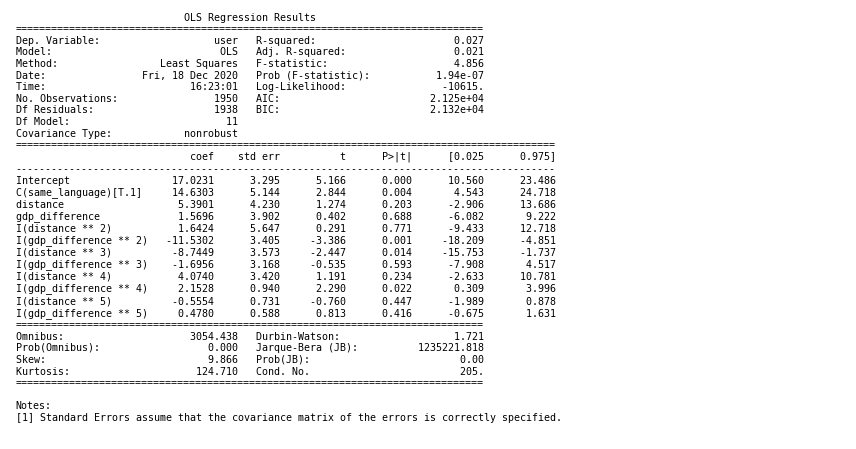

In [141]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('polynomial_reg_gowalla.png')

In [142]:
brightkite_trips_full_reg = brightkite_trips_full.copy()
brightkite_trips_full_reg['distance'] = (brightkite_trips_full_reg['distance'] - brightkite_trips_full_reg['distance'].mean())/brightkite_trips_full_reg['distance'].std()
brightkite_trips_full_reg['gdp_difference'] = (brightkite_trips_full_reg['gdp_difference'] - brightkite_trips_full_reg['gdp_difference'].mean())/brightkite_trips_full_reg['gdp_difference'].std()

In [143]:
mod = smf.ols(formula='user ~  distance + gdp_difference + C(same_language) \
              + I(distance**2) + I(gdp_difference**2) + I(distance**3) + I(gdp_difference**3) \
              + I(distance**4) + I(gdp_difference**4) + I(distance**5) + I(gdp_difference**5)', data=brightkite_trips_full_reg)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   user   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     4.934
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           1.37e-07
Time:                        16:23:08   Log-Likelihood:                -9571.1
No. Observations:                1955   AIC:                         1.917e+04
Df Residuals:                    1943   BIC:                         1.923e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11

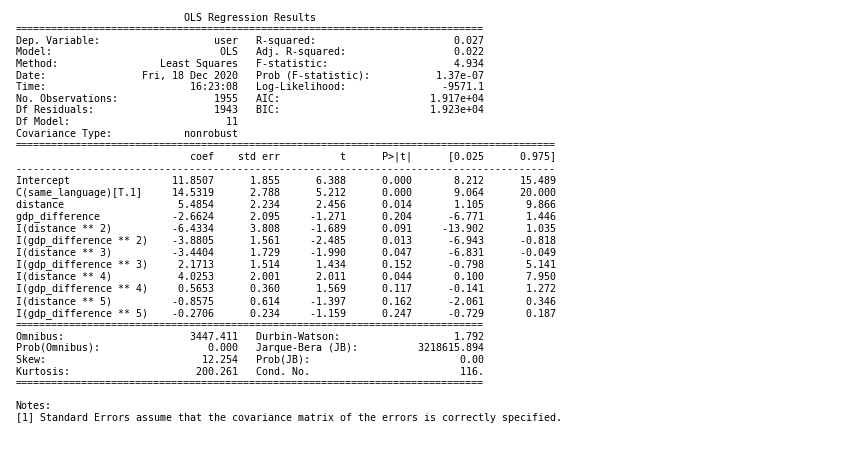

In [144]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(res.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('polynomial_reg_brightkite.png')

# 3. Comparison between American and European users

We will be interested in the following topics :
- Average distance 
- Part of the population going out of the country to travel 
- Number of visited country per traveller  

In [147]:
continents['country'] = continents['country'].str.lower()
continents['region'] = continents['region'].str.lower()
continents['continent'] = continents['continent'].str.lower()
continents.sample(2)

,country,code,region,continent
14,austria,AUT,western europe,europe
10,argentina,ARG,south america,south america


In [148]:
# Adds the contients of the home country for trips
gowalla_trips_full = pd.merge(gowalla_trips_full, continents[['country', 'continent']], how = 'left', left_on = 'country_home', right_on = 'country')
gowalla_trips_full.drop(columns = ['country'], inplace = True)
gowalla_trips_full.rename(columns = {'continent':'continent_home'}, inplace = True)
gowalla_trips_full.head(2)

,country_home,country_checkin,user,distance,language_home,language_checkin,same_language,gdp_difference,continent_home
0,afghanistan,belgium,1,5400.722789,dari,dutch,0,-28400.0,asia
1,afghanistan,united arab emirates,1,1684.946973,dari,arabic,0,-22500.0,asia


In [149]:
# Adds the contients of the home country fro trips
brightkite_trips_full = pd.merge(brightkite_trips_full, continents[['country', 'continent']], how = 'left', left_on = 'country_home', right_on = 'country')
brightkite_trips_full.drop(columns = ['country'], inplace = True)
brightkite_trips_full.rename(columns = {'continent':'continent_home'}, inplace = True)
brightkite_trips_full.head(2)

,country_home,country_checkin,user,distance,language_home,language_checkin,same_language,gdp_difference,continent_home
0,algeria,france,1,1511.896058,arabic,french,0,-21600.0,africa
1,angola,portugal,1,5889.419408,portuguese,portuguese,1,-16100.0,africa


## 3.1 Average distance traveled by people when they leave their country

In [150]:
# Adds the contients of the home location for far check-ins
gowalla_far_checkins = pd.merge(gowalla_far_checkins, continents[['country', 'continent']], how = 'left', left_on = 'country_home', right_on = 'country')
gowalla_far_checkins.drop(columns = ['country'], inplace = True)
gowalla_far_checkins.rename(columns = {'continent':'continent_home'}, inplace = True)
gowalla_far_checkins.sample(5)

,user,time,lat,lon,location_id,latitude_cell_number,longitude_cell_number,country_checkin,home_lat,home_lon,country_home,distance_from_home,previous_country_checkin,change_arrival_country,not_home_country,continent_home
789537,112926,2010-05-23 10:11:46+00:00,50.629668,-3.312234,903341,223.0,-10.0,united kingdom,51.529342,-0.126185,united kingdom,243.990593,sweden,1,0,europe
787690,112385,2009-10-17 23:42:10+00:00,42.354009,-83.080051,52037,187.0,-274.0,united states,41.912254,-87.637853,united states,378.989638,united states,0,0,north america
917161,163612,2010-09-28 17:13:13+00:00,60.193511,11.098251,66171,266.0,24.0,norway,59.648596,17.930149,sweden,385.353075,norway,0,1,europe
700375,89561,2010-09-06 04:27:47+00:00,37.591623,127.034072,1205903,166.0,448.0,"korea, republic of",59.342171,18.023535,sweden,7433.314050,"korea, republic of",0,1,europe
510439,34337,2010-06-21 04:53:36+00:00,36.113107,-115.176759,56265,159.0,-415.0,united states,32.752801,-117.160546,united states,415.561614,united states,0,0,north america


In [151]:
# Adds the contients of the home location for far check-ins
brightkite_far_checkins = pd.merge(brightkite_far_checkins, continents[['country', 'continent']], how = 'left', left_on = 'country_home', right_on = 'country')
brightkite_far_checkins.drop(columns = ['country'], inplace = True)
brightkite_far_checkins.rename(columns = {'continent':'continent_home'}, inplace = True)
brightkite_far_checkins.head()

,user,time,lat,lon,location_id,latitude_cell_number,longitude_cell_number,country_checkin,home_lat,home_lon,country_home,distance_from_home,previous_country_checkin,change_arrival_country,not_home_country,continent_home
0,0,2010-05-07 22:34:54+00:00,37.615223,-122.389979,f0ed8591044a8214451d9c04607ccbfb,166.0,-432.0,united states,39.746677,-104.973619,united states,1527.749989,NaN,1,0,north america
1,0,2010-05-07 21:10:40+00:00,37.579361,-122.346108,ca094b92244011de8447003048c0801e,166.0,-432.0,united states,39.746677,-104.973619,united states,1524.996827,united states,0,0,north america
2,0,2010-05-07 18:18:37+00:00,37.578379,-122.347524,31c4ef9bbd5f8ebe234058cbb6d265af,166.0,-432.0,united states,39.746677,-104.973619,united states,1525.144928,united states,0,0,north america
3,0,2010-05-07 18:13:36+00:00,37.579361,-122.346108,ca094b92244011de8447003048c0801e,166.0,-432.0,united states,39.746677,-104.973619,united states,1524.996827,united states,0,0,north america
4,0,2010-05-07 02:46:58+00:00,37.785078,-122.404998,8d788309d5057922a69ea575f8fc4ea7acbab45c,167.0,-431.0,united states,39.746677,-104.973619,united states,1524.471959,united states,0,0,north america


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


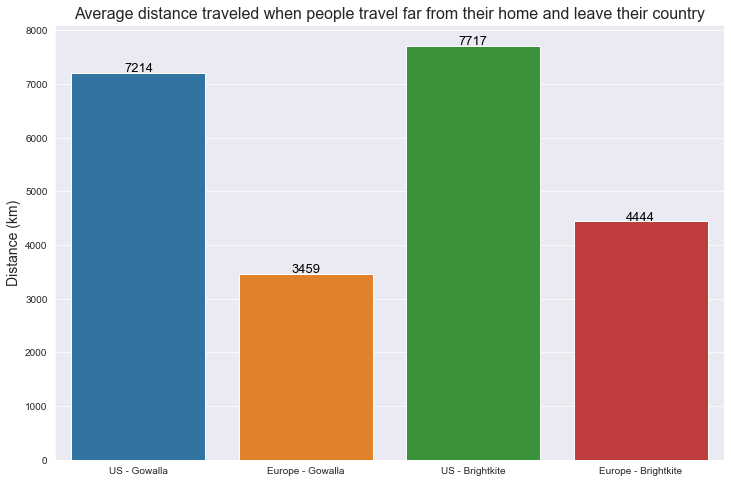

In [158]:
# Average distance traveled by Amercian people when they go out of their country for a long trip (i.e. distance greater than 200 km from their home)
gowalla_us_dist = gowalla_far_checkins[(gowalla_far_checkins.country_home == 'united states') & (gowalla_far_checkins.country_home != gowalla_far_checkins.country_checkin)].distance_from_home.mean()

# Average distance traveled by European people when they go out of their country for a long trip (i.e. distance greater than 200 km from their home)
gowalla_eu_dist = gowalla_far_checkins[(gowalla_far_checkins.continent_home == 'europe') & (gowalla_far_checkins.country_home != gowalla_far_checkins.country_checkin)].distance_from_home.mean()

# Idem for Brightkite :
brightkite_us_dist = brightkite_far_checkins[(brightkite_far_checkins.country_home == 'united states')& (brightkite_far_checkins.country_home != brightkite_far_checkins.country_checkin)].distance_from_home.mean()
brightkite_eu_dist = brightkite_far_checkins[(brightkite_far_checkins.continent_home == 'europe') & (brightkite_far_checkins.country_home != brightkite_far_checkins.country_checkin)].distance_from_home.mean()

# Let's plot an histogram to visualise this
y=[gowalla_us_dist, gowalla_eu_dist, brightkite_us_dist, brightkite_eu_dist]

x=['US - Gowalla', 'Europe - Gowalla', 'US - Brightkite', 'Europe - Brightkite'] 

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
fig = sns.barplot(x,y)
fig.set_title('Average distance traveled when people travel far from their home and leave their country', fontsize = 16)
fig.set_ylabel('Distance (km)', fontsize = 14)
fig.text(0, 7234, s = round(y[0]), color='black', ha="center", fontsize = 13)
fig.text(1, 3479, s = round(y[1]), color='black', ha="center", fontsize = 13)
fig.text(2, 7737, s = round(y[2]), color='black', ha="center", fontsize = 13)
fig.text(3, 4464, s = round(y[3]), color='black', ha="center", fontsize = 13)
fig = fig.get_figure()
fig.savefig("distance_eu_vs_us.png")

## 3.1.1 What if they stay in the country ?

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


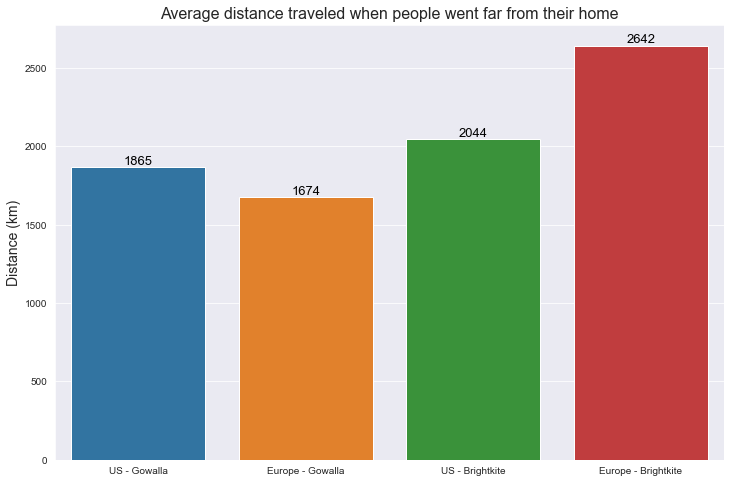

In [160]:
# Same syntax as before, but without the condition of having a different country between the check-in and the home location
gowalla_us_dist_2 = gowalla_far_checkins[gowalla_far_checkins.country_home == 'united states'].distance_from_home.mean()
gowalla_eu_dist_2 = gowalla_far_checkins[gowalla_far_checkins.continent_home == 'europe'].distance_from_home.mean()
brightkite_us_dist_2 = brightkite_far_checkins[brightkite_far_checkins.country_home == 'united states'].distance_from_home.mean()
brightkite_eu_dist_2 = brightkite_far_checkins[brightkite_far_checkins.continent_home == 'europe'].distance_from_home.mean()

y=[gowalla_us_dist_2, gowalla_eu_dist_2, brightkite_us_dist_2, brightkite_eu_dist_2]

x=['US - Gowalla', 'Europe - Gowalla', 'US - Brightkite', 'Europe - Brightkite'] 

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
fig = sns.barplot(x,y)
fig.set_title('Average distance traveled when people went far from their home', fontsize = 16)
fig.set_ylabel('Distance (km)', fontsize = 14)
fig.text(0, 1885, s = round(y[0]), color='black', ha="center", fontsize = 13)
fig.text(1, 1694, s = round(y[1]), color='black', ha="center", fontsize = 13)
fig.text(2, 2064, s = round(y[2]), color='black', ha="center", fontsize = 13)
fig.text(3, 2662, s = round(y[3]), color='black', ha="center", fontsize = 13)
fig = fig.get_figure()
fig.savefig("distance_wihout_leaving_country_eu_vs_us.png")

## 3.2 Part of the population going out of the country to travel 

In [161]:
# Number of people who left the US to travel
gowalla_us_travel_out_of_country = gowalla_far_checkins[(gowalla_far_checkins.country_checkin != gowalla_far_checkins.country_home) & (gowalla_far_checkins.country_home == 'united states')].user.nunique()

# Total number of American people who travel 
gowalla_us_total = gowalla_far_checkins[(gowalla_far_checkins.country_home == 'united states')].user.nunique()

In [162]:
# Idem for Brightkite
brightkite_us_travel_out_of_country = brightkite_far_checkins[(brightkite_far_checkins.country_checkin != brightkite_far_checkins.country_home) & (brightkite_far_checkins.country_home == 'united states')].user.nunique()
brightkite_us_total = brightkite_far_checkins[(brightkite_far_checkins.country_home == 'united states')].user.nunique()

In [163]:
# Number of people who left their country in Europe to travel
gowalla_eu_travel_out_of_country = gowalla_far_checkins[(gowalla_far_checkins.country_checkin != gowalla_far_checkins.country_home) & (gowalla_far_checkins.continent_home == 'europe')].user.nunique()

# Total number of European people who travel 
gowalla_eu_total = gowalla_far_checkins[(gowalla_far_checkins.continent_home == 'europe')].user.nunique()

In [164]:
# Idem for Brightkite
brightkite_eu_travel_out_of_country = brightkite_far_checkins[(brightkite_far_checkins.country_checkin != brightkite_far_checkins.country_home) & (brightkite_far_checkins.continent_home == 'europe')].user.nunique()
brightkite_eu_total = brightkite_far_checkins[(brightkite_far_checkins.continent_home == 'europe')].user.nunique()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


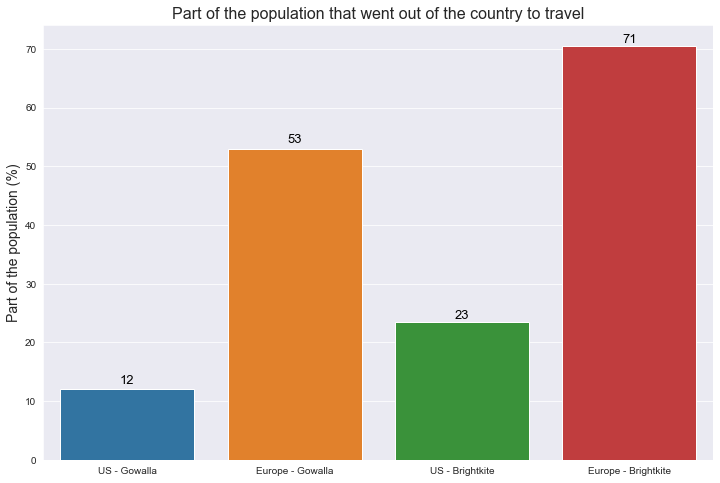

In [166]:
# Let's plot this with an histogram 
y=[100*gowalla_us_travel_out_of_country/gowalla_us_total, 
   100*gowalla_eu_travel_out_of_country/gowalla_eu_total,
   100*brightkite_us_travel_out_of_country/brightkite_us_total,
   100*brightkite_eu_travel_out_of_country/brightkite_eu_total]

x=['US - Gowalla', 'Europe - Gowalla', 'US - Brightkite', 'Europe - Brightkite'] 

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
fig = sns.barplot(x,y)
fig.set_title('Part of the population that went out of the country to travel', fontsize = 16) 
fig.set_ylabel('Part of the population (%)', fontsize = 14)
fig.text(0, 13, s = round(y[0]), color='black', ha="center", fontsize = 13)
fig.text(1, 54, s = round(y[1]), color='black', ha="center", fontsize = 13)
fig.text(2, 24, s = round(y[2]), color='black', ha="center", fontsize = 13)
fig.text(3, 71, s = round(y[3]), color='black', ha="center", fontsize = 13)
fig = fig.get_figure()
fig.savefig("part_of_pop_out_eu_vs_us.png")

## 3.2.1 Part of the population going out of the continent to travel 

In [167]:
# Adding the continent where the check-in was done 
gowalla_far_checkins = pd.merge(gowalla_far_checkins, continents[['country', 'continent']], how = 'left', left_on = 'country_checkin', right_on = 'country')
gowalla_far_checkins.drop(columns = ['country'], inplace = True)
gowalla_far_checkins.rename(columns = {'continent':'continent_checkin'}, inplace = True)
gowalla_far_checkins.sample(3)

,user,time,lat,lon,location_id,latitude_cell_number,longitude_cell_number,country_checkin,home_lat,home_lon,country_home,distance_from_home,previous_country_checkin,change_arrival_country,not_home_country,continent_home,continent_checkin
689878,81990,2010-09-01 17:59:24+00:00,35.226601,-97.431009,2874616,155.0,-355.0,united states,37.806326,-122.414888,united states,2244.278209,united states,0,0,north america,north america
364604,16099,2010-10-05 14:48:09+00:00,1.470048,103.732202,1258902,6.0,461.0,malaysia,22.187663,113.546797,macao,2536.482910,malaysia,0,1,NaN,asia
173929,3449,2010-06-29 20:39:43+00:00,34.040534,-118.426116,854157,150.0,-437.0,united states,39.944514,116.447420,china,10046.627710,united states,0,1,asia,north america


In [168]:
# Adding the continent where the check-in was done 
brightkite_far_checkins = pd.merge(brightkite_far_checkins, continents[['country', 'continent']], how = 'left', left_on = 'country_checkin', right_on = 'country')
brightkite_far_checkins.drop(columns = ['country'], inplace = True)
brightkite_far_checkins.rename(columns = {'continent':'continent_checkin'}, inplace = True)
brightkite_far_checkins.sample(3)

,user,time,lat,lon,location_id,latitude_cell_number,longitude_cell_number,country_checkin,home_lat,home_lon,country_home,distance_from_home,previous_country_checkin,change_arrival_country,not_home_country,continent_home,continent_checkin
181092,4988,2008-11-06 00:49:15+00:00,39.878664,-104.682105,e12721ce84e911dd8019003048c0801e,176.0,-358.0,united states,47.621448,-122.328946,united states,1652.672973,united states,0,0,north america,north america
460561,29468,2008-12-25 22:19:52+00:00,36.135524,-86.667690,7ee80cfabcc811ddb822003048c0801e,159.0,-312.0,united states,38.991552,-76.386458,united states,959.569466,united states,0,0,north america,north america
68466,1315,2009-07-04 23:12:41+00:00,38.685736,-121.372174,ee7c9324a22411ddae93f7644f8354bf,171.0,-422.0,united states,39.981631,-105.140666,united states,1401.458039,united states,0,0,north america,north america


In [169]:
# Number of North American people who left North Amercia to travel
gowalla_us_travel_out_of_continent = gowalla_far_checkins[(gowalla_far_checkins.continent_checkin != gowalla_far_checkins.continent_home) & (gowalla_far_checkins.continent_home == 'north america')].user.nunique()

# Total number of North American travelers 
gowalla_us_total_continent = gowalla_far_checkins[(gowalla_far_checkins.continent_home == 'north america')].user.nunique()

In [170]:
# Number of European people who left Europe to travel
gowalla_eu_travel_out_of_continent = gowalla_far_checkins[(gowalla_far_checkins.continent_checkin != gowalla_far_checkins.continent_home) & (gowalla_far_checkins.continent_home == 'europe')].user.nunique()

# Total number of European travelers 
gowalla_eu_total_continent = gowalla_far_checkins[(gowalla_far_checkins.continent_home == 'europe')].user.nunique()

In [171]:
# idem for Brightkite
brightkite_us_travel_out_of_continent = brightkite_far_checkins[(brightkite_far_checkins.continent_checkin != brightkite_far_checkins.continent_home) & (brightkite_far_checkins.continent_home == 'north america')].user.nunique()
brightkite_us_total_continent = brightkite_far_checkins[(brightkite_far_checkins.continent_home == 'north america')].user.nunique()

In [172]:
# idem for Brightkite
brightkite_eu_travel_out_of_continent = brightkite_far_checkins[(brightkite_far_checkins.continent_checkin != brightkite_far_checkins.continent_home) & (brightkite_far_checkins.continent_home == 'europe')].user.nunique()
brightkite_eu_total_continent = brightkite_far_checkins[(brightkite_far_checkins.continent_home == 'europe')].user.nunique()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


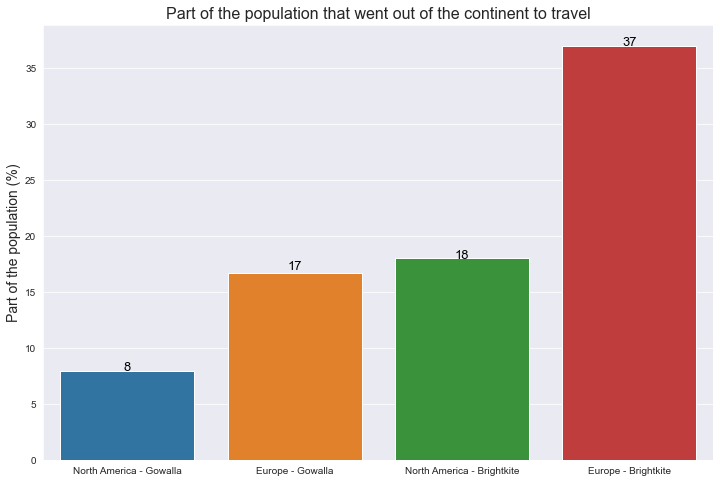

In [176]:
# Let's plot this with an histogram 
y=[100*gowalla_us_travel_out_of_continent/gowalla_us_total_continent, 
   100*gowalla_eu_travel_out_of_continent/gowalla_eu_total_continent,
   100*brightkite_us_travel_out_of_continent/brightkite_us_total_continent,
   100*brightkite_eu_travel_out_of_continent/brightkite_eu_total_continent]

x=['North America - Gowalla', 'Europe - Gowalla', 'North America - Brightkite', 'Europe - Brightkite'] 

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
fig = sns.barplot(x,y)
fig.set_title('Part of the population that went out of the continent to travel', fontsize = 16)
fig.set_ylabel('Part of the population (%)', fontsize = 14)
fig.text(0, 8, s = round(y[0]), color='black', ha="center", fontsize = 13)
fig.text(1, 17, s = round(y[1]), color='black', ha="center", fontsize = 13)
fig.text(2, 18, s = round(y[2]), color='black', ha="center", fontsize = 13)
fig.text(3, 37, s = round(y[3]), color='black', ha="center", fontsize = 13)
fig = fig.get_figure()
fig.savefig("part_of_pop_out_continent_eu_vs_us.png")

## 3.3 Average number of visited countries per traveller

In [177]:
# Total number of American people who traveled out of the US
gowalla_us_travel_out_of_country = gowalla_far_checkins[(gowalla_far_checkins.country_checkin != gowalla_far_checkins.country_home) & (gowalla_far_checkins.country_home == 'united states')].user.nunique()
# Total number of visited countries by American inhabitants 
gowalla_us_number_visited_contries = gowalla_trips_full[gowalla_trips_full.country_home == 'united states'].user.sum()

brightkite_us_travel_out_of_country = brightkite_far_checkins[(brightkite_far_checkins.country_checkin != brightkite_far_checkins.country_home) & (brightkite_far_checkins.country_home == 'united states')].user.nunique()
brightkite_us_number_visited_contries = brightkite_trips_full[brightkite_trips_full.country_home == 'united states'].user.sum()

gowalla_eur_travel_out_of_country = gowalla_far_checkins[(gowalla_far_checkins.country_checkin != gowalla_far_checkins.country_home) & (gowalla_far_checkins.continent_home == 'europe')].user.nunique()
gowalla_eur_number_visited_contries = gowalla_trips_full[gowalla_trips_full.continent_home == 'europe'].user.sum()

brightkite_eur_travel_out_of_country = brightkite_far_checkins[(brightkite_far_checkins.country_checkin != brightkite_far_checkins.country_home) & (brightkite_far_checkins.continent_home == 'europe')].user.nunique()
brightkite_eur_number_visited_contries = brightkite_trips_full[brightkite_trips_full.continent_home == 'europe'].user.sum()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


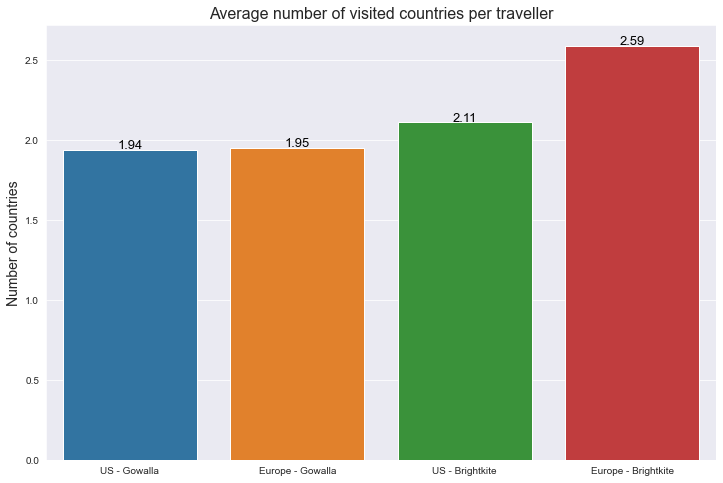

In [180]:
# Let's plot this with an histogram 
y=[gowalla_us_number_visited_contries/gowalla_us_travel_out_of_country, 
   gowalla_eur_number_visited_contries/gowalla_eur_travel_out_of_country,
   brightkite_us_number_visited_contries/brightkite_us_travel_out_of_country,
   brightkite_eur_number_visited_contries/brightkite_eur_travel_out_of_country]

x=['US - Gowalla', 'Europe - Gowalla', 'US - Brightkite', 'Europe - Brightkite'] 

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
fig = sns.barplot(x,y)
fig.set_title('Average number of visited countries per traveller', fontsize = 16)
fig.set_ylabel('Number of countries', fontsize = 14)
fig.text(0, 1.95, s = round(y[0], 2), color='black', ha="center", fontsize = 13)
fig.text(1, 1.96, s = round(y[1], 2), color='black', ha="center", fontsize = 13)
fig.text(2, 2.12, s = round(y[2], 2), color='black', ha="center", fontsize = 13)
fig.text(3, 2.60, s = round(y[3], 2), color='black', ha="center", fontsize = 13)
fig = fig.get_figure()
fig.savefig("countries_per_traveller_eu_vs_us.png")